Need to still work on this - how to 'clean' signal before using it for analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d

In [2]:
# Reload the provided file and check its structure


file_path = "/home/toor/Desktop/rawFdF.npy"

try:
    raw_FdF = np.load(file_path, allow_pickle=True)  # Load data
    data_shape = raw_FdF.shape
    data_dtype = raw_FdF.dtype
    sample_values = raw_FdF[:5]  # Extract a small sample for inspection

    result = {
        "shape": data_shape,
        "dtype": str(data_dtype),
        "sample_values": sample_values
    }
except Exception as e:
    result = {"error": str(e)}

result


{'shape': (1304, 22506),
 'dtype': 'float64',
 'sample_values': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.31174242e+00,  1.05397462e+00,  8.27917247e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.12557532e-07, -1.26627223e-07, -1.40696915e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.97308474e-03, -4.35711279e-03, -4.72037436e-03],
        [-1.78613199e-02, -1.78613199e-02, -1.78613199e-02, ...,
          7.62182251e-01,  7.23154039e-01,  6.86091164e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          6.93245218e+00,  6.41502063e+00,  5.92433730e+00]])}

In [3]:
# Function to preprocess the calcium signals
def preprocess_calcium(raw_data, smoothing_kernel=5, baseline_window=1000):
    """
    Preprocess one-photon calcium imaging signals.
    
    Steps:
    1. Median filtering for noise reduction.
    2. Baseline correction using rolling percentile.
    3. ΔF/F normalization.
    4. Z-score transformation.
    
    Parameters:
    - raw_data: numpy array (neurons x timepoints)
    - smoothing_kernel: kernel size for median filter
    - baseline_window: window size for local baseline estimation
    
    Returns:
    - preprocessed_data: numpy array (neurons x timepoints)
    """
    num_neurons, num_timepoints = raw_data.shape
    preprocessed_data = np.zeros_like(raw_data)
    
    for i in range(num_neurons):
        signal = raw_data[i, :]

        # Step 1: Noise reduction with median filtering
        smoothed_signal = medfilt(signal, kernel_size=smoothing_kernel)
        
        # Step 2: Baseline correction using rolling percentile
        baseline = np.percentile(smoothed_signal[:baseline_window], 10)  # 10th percentile baseline
        dF_F = (smoothed_signal - baseline) / (baseline + 1e-6)  # Avoid division by zero
        
        preprocessed_data[i, :] = dF_F

    return preprocessed_data


In [4]:
# Apply preprocessing
preprocessed_FdF = preprocess_calcium(raw_FdF)

# # Save the preprocessed data
# preprocessed_file_path = "/home/toor/Desktop/preprocessed_FdF.npy"
# np.save(preprocessed_file_path, preprocessed_FdF)

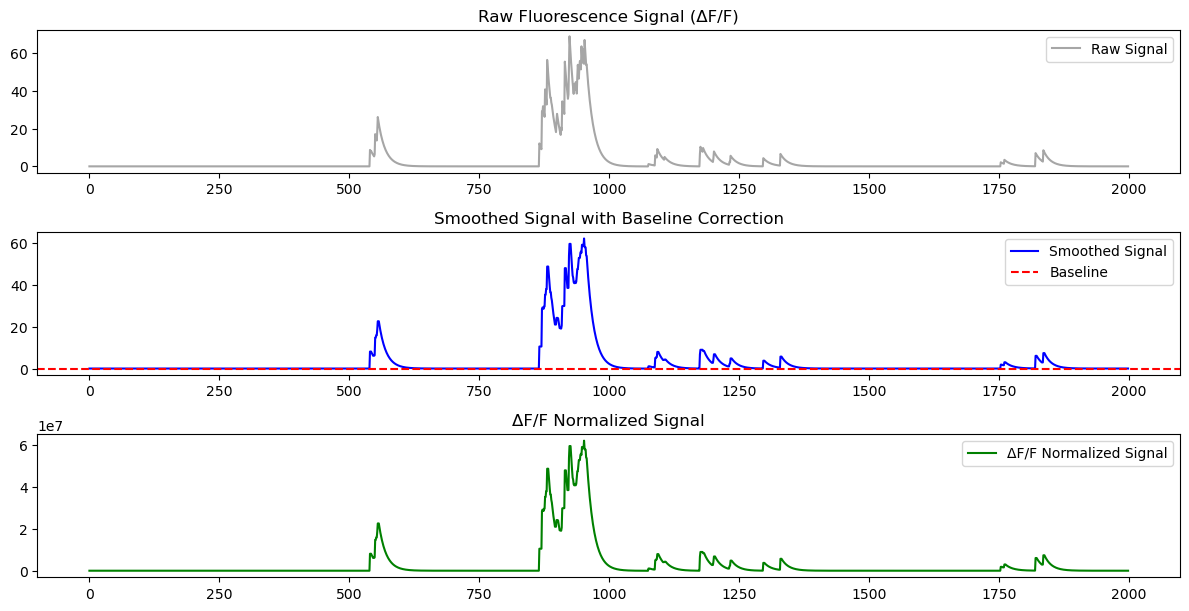

In [5]:
# Select a sample neuron to visualize preprocessing steps
sample_neuron_idx = 101
raw_signal = raw_FdF[sample_neuron_idx, :]
smoothed_signal = medfilt(raw_signal, kernel_size=5)
baseline = np.percentile(smoothed_signal[:1000], 10)
dF_F = (smoothed_signal - baseline) / (baseline + 1e-6)
zscored_signal = (dF_F - np.mean(dF_F)) / (np.std(dF_F) + 1e-6)

# Plot each step of preprocessing
plt.figure(figsize=(12, 8))

# Raw signal
plt.subplot(4, 1, 1)
plt.plot(raw_signal[0:2000], color='gray', alpha=0.7, label="Raw Signal")
plt.title("Raw Fluorescence Signal (ΔF/F)")
plt.legend()

# Smoothed signal
plt.subplot(4, 1, 2)
plt.plot(smoothed_signal[0:2000], color='blue', label="Smoothed Signal")
plt.axhline(baseline, color='red', linestyle='--', label="Baseline")
plt.title("Smoothed Signal with Baseline Correction")
plt.legend()

# ΔF/F Normalization
plt.subplot(4, 1, 3)
plt.plot(dF_F[0:2000], color='green', label="ΔF/F Normalized Signal")
plt.title("ΔF/F Normalized Signal")
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
zscored_signal

array([-0.34357362, -0.34357362, -0.34357362, ..., -0.27089222,
       -0.30368186, -0.33416202])

In [7]:
np.sum(dF_F < 0)

1093

In [8]:
dF_F[:][21016]

-529151.8289498312

In [9]:
dF_F[:][21016]

-529151.8289498312